In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import json
from scipy.spatial import distance
import math
import random
from IPython.display import display, clear_output, HTML
import copy

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Timing**

In [ ]:
df_time_between_stops = pd.read_csv("2030 Time Between Stops By Line.csv")
display(df_time_between_stops)

# Create a dictionary mapping line numbers to travel times
line_to_time = dict(zip(df_time_between_stops["Line"], df_time_between_stops["Time Between Stops (mins)"]))

,Line,Time Between Stops (mins)
0,1.0,1.500
1,2.0,1.375
2,3.0,1.292
3,3.5,1.000
4,4.0,1.250
5,5.0,1.619
6,6.0,1.269
7,7.0,1.424
8,7.5,1.000
9,8.0,1.378


## **Read in the Graph**

Unique Metro Lines: {1, 2, 3, 4, 5, 6, 7, 8, 9, 7.5, 11, 12, 13, 14, 10, 3.5, 15, 16, 17, 18}


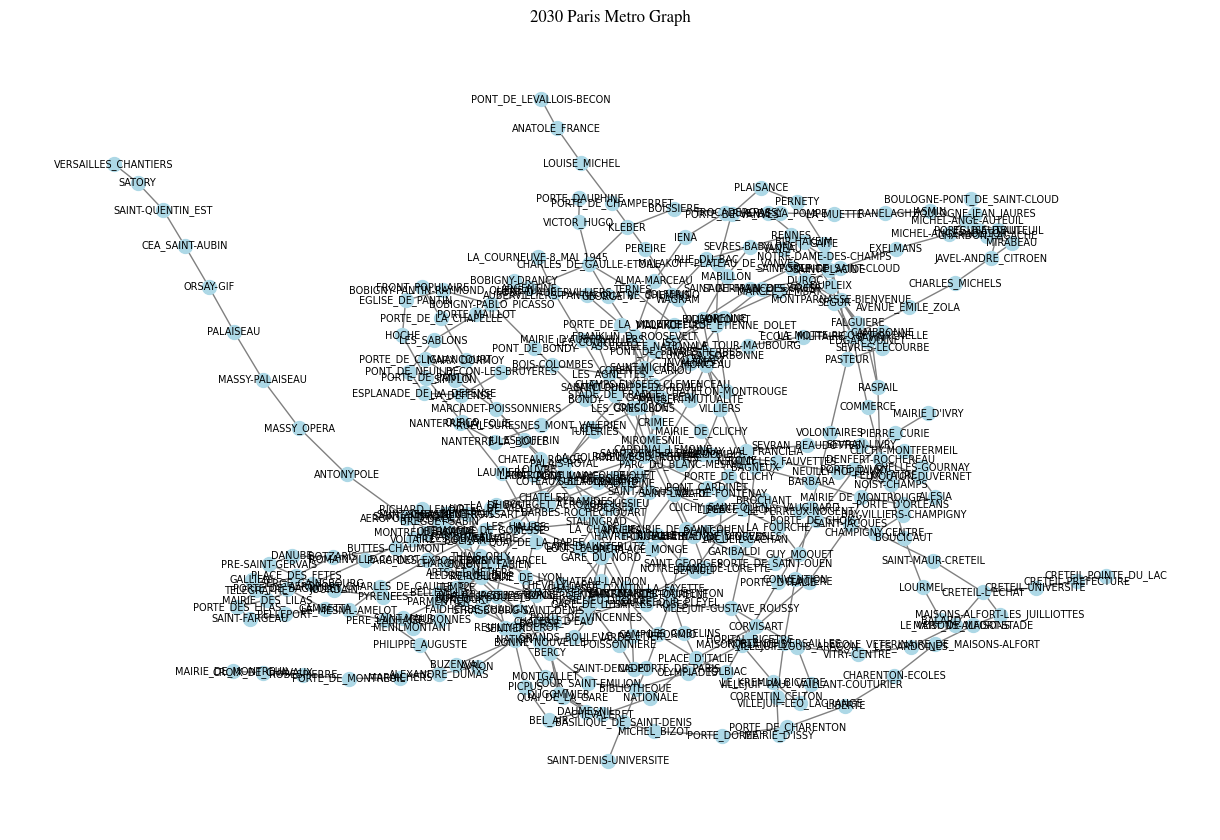

# of edges: 442


In [ ]:
# Initialize an empty graph
G = nx.Graph()

# Initialize an empty set to store metro lines
metro_lines = set()

# Read the graph file manually and parse edges
with open("2030_graph_all_lines.txt", "r", encoding="utf-8") as file:
    for line in file:
        parts = line.strip().split(" ", 2)  # Split into first two parts + label dictionary
        if len(parts) == 3:
            node1, node2, attr_str = parts
            try:
                # Convert the attribute string into a dictionary
                attr_dict = eval(attr_str)  # Be cautious with eval() if the file is untrusted

                G.add_edge(node1, node2, **attr_dict)
            except SyntaxError:
                print(f"Skipping invalid line: {line.strip()}")

# Add traversal time as an edge attribute based on the line number
for u, v, data in G.edges(data=True):
    line = data.get("label")
    if line in line_to_time:
        G[u][v]["time"] = line_to_time[line]  # Assign travel time

# Extract all unique Metro lines from edge attributes
for edge in G.edges(data=True):
    line = edge[2].get("label")
    if line:
        metro_lines.add(line)

print(f"Unique Metro Lines: {metro_lines}")  # Print to check

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=100, font_size=7)
plt.title("2030 Paris Metro Graph")
plt.show()
print("# of edges:", G.number_of_edges())

## **Traveling Between Every Two Stations**

In [ ]:
def calculate_shortest_paths_with_time(G):
    """Calculates shortest paths and travel times between all station pairs.

    Args:
        G: The NetworkX graph representing the Metro network.

    Returns:
        A list of dictionaries, where each dictionary represents a path
        with 'origin', 'destination', and 'travel_time' keys.
    """

    all_paths = []
    for origin in G.nodes():
        for destination in G.nodes():
            if origin != destination:  # Avoid paths to itself
                try:
                    # Get the shortest path
                    path = nx.shortest_path(G, source=origin, target=destination, weight="time")

                    # Calculate total travel time
                    travel_time = calculate_path_time(G, path)

                    all_paths.append({
                        'origin': origin,
                        'destination': destination,
                        'path': path,  # Include the path itself
                        'travel_time': travel_time
                    })
                except nx.NetworkXNoPath:
                    print(f"No path found between {origin} and {destination}")

    return all_paths

def calculate_path_time(G, path):
  """Calculates the total travel time for a given path,
  including a 4.50-minute penalty for each transfer."""

  total_time = 0
  transfers = 0  # Initialize transfer count

  for i in range(len(path) - 1):
    u, v = path[i], path[i + 1]
    try:
      time = G[u][v]["time"]
      total_time += time

      # Check for transfers (if not the first edge)
      if i > 0:
        current_line = G[path[i - 1]][path[i]].get("label")  # Get the line of the previous edge
        next_line = G[u][v].get("label")  # Get the line of the current edge

        if current_line != next_line:  # If lines are different, it's a transfer
          transfers += 1

    except KeyError:
      print(f"Warning: No time attribute found for edge ({u}, {v}). Skipping...")

  # Add transfer penalty to total time
  total_time += transfers * 4.50
  return total_time

all_paths_with_time = calculate_shortest_paths_with_time(G)

# Create a DataFrame to store the results
df_all_paths = pd.DataFrame(all_paths_with_time)

# Display or save the DataFrame as needed
display(df_all_paths)

average_time = df_all_paths['travel_time'].mean()
print(f"Average time for all paths (mins): {average_time}")

# df_all_paths.to_csv('all_paths_with_time_2030.csv', index=False)

,origin,destination,path,travel_time
0,REPUBLIQUE,TEMPLE,"[REPUBLIQUE, TEMPLE]",1.292
1,REPUBLIQUE,PARMENTIER,"[REPUBLIQUE, PARMENTIER]",1.292
2,REPUBLIQUE,OBERKAMPF,"[REPUBLIQUE, OBERKAMPF]",1.389
3,REPUBLIQUE,STRASBOURG-SAINT-DENIS,"[REPUBLIQUE, STRASBOURG-SAINT-DENIS]",1.389
4,REPUBLIQUE,GONCOURT,"[REPUBLIQUE, GONCOURT]",1.389
...,...,...,...,...
135051,ESPLANADE_DE_LA_DEFENSE,VICTOR_HUGO,"[ESPLANADE_DE_LA_DEFENSE, PONT_DE_NEUILLY, LES...",13.375
135052,ESPLANADE_DE_LA_DEFENSE,PORTE_DAUPHINE,"[ESPLANADE_DE_LA_DEFENSE, PONT_DE_NEUILLY, LES...",14.750
135053,ESPLANADE_DE_LA_DEFENSE,GEORGE_V,"[ESPLANADE_DE_LA_DEFENSE, PONT_DE_NEUILLY, LES...",9.000
135054,ESPLANADE_DE_LA_DEFENSE,LES_SABLONS,"[ESPLANADE_DE_LA_DEFENSE, PONT_DE_NEUILLY, LES...",3.000


Average time for all paths (mins): 34.03713986790664


In [ ]:
def count_paths_using_line(df_all_paths, metro_line):
    """Counts the number of paths in df_all_paths that use the given metro_line."""
    count = 0
    for index, row in df_all_paths.iterrows():
        path = row['path']  # Assuming 'path' column contains the list of nodes in the path
        path_edges = list(zip(path[:-1], path[1:]))  # Create edges from the path nodes

        # Check if any edge in the path has the current metro_line label
        for u, v in path_edges:
            edge_data = G.get_edge_data(u, v)  # Get edge data from the graph G
            if edge_data and edge_data.get("label") == metro_line:
                count += 1
                break  # Break inner loop if the line is found in the path

    return count

# Create a dictionary to store line counts
line_counts = {}

# Loop through each metro line and print the count
for line in metro_lines:
    path_count = count_paths_using_line(df_all_paths, line)
    line_counts[line] = path_count
    print(f"Number of paths using line {line}: {path_count}")

Number of paths using line 1: 36546
Number of paths using line 2: 22546
Number of paths using line 3: 28790
Number of paths using line 4: 33350
Number of paths using line 5: 22018
Number of paths using line 6: 33648
Number of paths using line 7: 41022
Number of paths using line 8: 33428
Number of paths using line 9: 29564
Number of paths using line 7.5: 6390
Number of paths using line 11: 19546
Number of paths using line 12: 30992
Number of paths using line 13: 31542
Number of paths using line 14: 54964
Number of paths using line 10: 17870
Number of paths using line 3.5: 4002
Number of paths using line 15: 36802
Number of paths using line 16: 5470
Number of paths using line 17: 5966
Number of paths using line 18: 6534


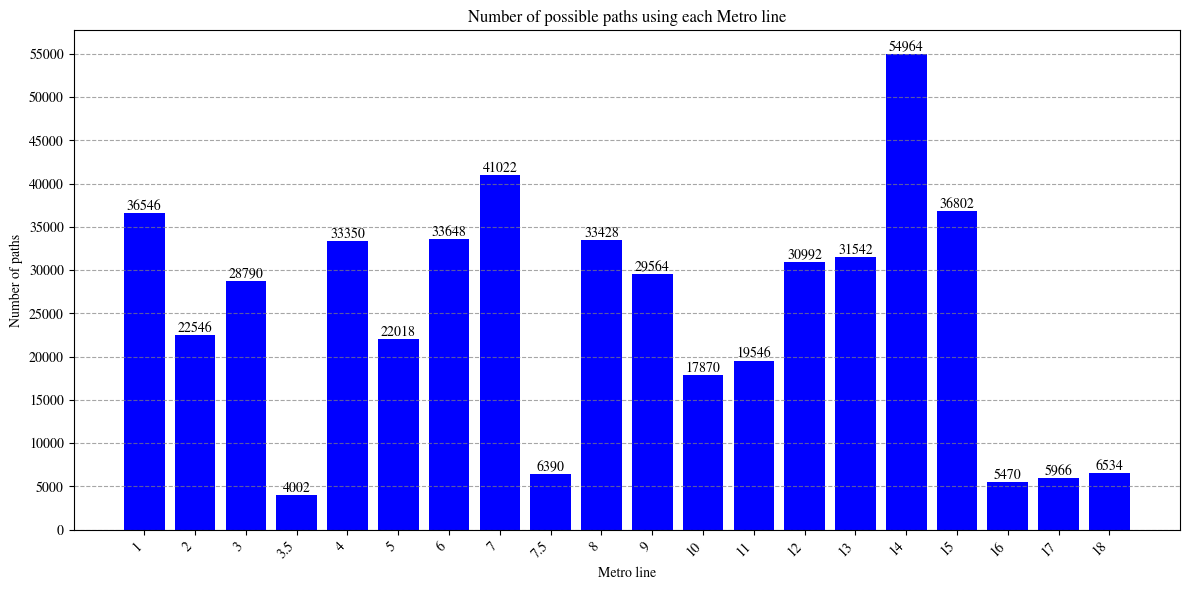

In [ ]:
# Sort lines and counts based on line number
sorted_lines_counts = sorted(line_counts.items(), key=lambda item: item[0])
lines = [item[0] for item in sorted_lines_counts]
counts = [item[1] for item in sorted_lines_counts]

# Create evenly spaced x-axis positions
x_pos = np.arange(len(lines))

# Create the bar graph
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(x_pos, counts, align='center', color='blue')

# Add values above each bar
for i, v in enumerate(counts):
    plt.text(x_pos[i], v + 0.5, str(v), ha='center', va='bottom')  # Adjust text position as needed

# Customize the graph
plt.yticks(np.arange(0, max(counts) + 500, 5000))  # Set y-axis ticks every 2 units
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)  # Add horizontal grid lines
plt.xlabel("Metro line")
plt.ylabel("Number of paths")
plt.title("Number of possible paths using each Metro line")
plt.xticks(x_pos, lines, rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

plt.savefig("number_of_paths_using_each_line.pdf", bbox_inches='tight')

## **Analyzing the Simulation Results**

In [ ]:
# These are the results from the simulation done in Part 4 Notebook

df_results_2030 = pd.read_csv("df_results_2030.csv")
df_results_2030 = df_results_2030.rename(columns={"path_time": "original_path_time"})
display(df_results_2030)

,person_id,path,original_path_time,origin,destination,transfer_stations
0,1,"['REPUBLIQUE', 'OBERKAMPF', 'SAINT-AMBROISE', ...",15.834,REPUBLIQUE,SAINT-MANDE-TOURELLE,['NATION']
1,2,"['REPUBLIQUE', 'OBERKAMPF', 'SAINT-AMBROISE', ...",17.334,REPUBLIQUE,BERAULT,['NATION']
2,3,"['REPUBLIQUE', 'STRASBOURG-SAINT-DENIS', 'BONN...",26.001,REPUBLIQUE,LA_TOUR-MAUBOURG,"['RICHELIEU-DROUOT', 'MADELEINE', 'CONCORDE']"
3,4,"['REPUBLIQUE', 'STRASBOURG-SAINT-DENIS', 'BONN...",30.467,REPUBLIQUE,SAINT-PHILIPPE-DU-ROULE,"['RICHELIEU-DROUOT', 'OPERA', 'SAINT-LAZARE', ..."
4,5,"['REPUBLIQUE', 'ARTS_ET_METIERS', 'RAMBUTEAU',...",32.687,REPUBLIQUE,VILLEJUIF-LOUIS_ARAGON,"['CHATELET', 'VILLEJUIF-GUSTAVE_ROUSSY']"
...,...,...,...,...,...,...
127387,127388,"['ESPLANADE_DE_LA_DEFENSE', 'PONT_DE_NEUILLY']",1.500,ESPLANADE_DE_LA_DEFENSE,PONT_DE_NEUILLY,[]
127388,127389,"['ESPLANADE_DE_LA_DEFENSE', 'LA_DEFENSE']",1.500,ESPLANADE_DE_LA_DEFENSE,LA_DEFENSE,[]
127389,127390,"['ESPLANADE_DE_LA_DEFENSE', 'PONT_DE_NEUILLY',...",40.440,ESPLANADE_DE_LA_DEFENSE,NATIONALE,"['CONCORDE', 'MADELEINE', 'BERCY']"
127390,127391,"['ESPLANADE_DE_LA_DEFENSE', 'LA_DEFENSE']",1.500,ESPLANADE_DE_LA_DEFENSE,LA_DEFENSE,[]


In [ ]:
# This closes one Metro line at a time but keeps all paths that have an origin or destination that is a "simple station" on the closed line.

def calculate_shortest_paths_with_closures_with_time(G, closed_line):
    """Calculates shortest paths and travel times between all station pairs,
    avoiding a specified Metro line.

    Args:
        G: The NetworkX graph representing the Metro network.
        closed_line: The Metro line number to avoid.

    Returns:
        A list of dictionaries, where each dictionary represents a path
        with 'origin', 'destination', and 'travel_time' keys.
    """

    # Create a subgraph without edges of the closed line
    subgraph = G.copy()  # Make a copy to avoid modifying original graph
    edges_to_remove = [(u, v) for u, v, data in subgraph.edges(data=True) if data.get("label") == closed_line]
    subgraph.remove_edges_from(edges_to_remove)

    all_paths = []
    for origin in G.nodes():
        for destination in G.nodes():
            if origin != destination:  # Avoid paths to itself
                try:
                    # Get the shortest path in the subgraph
                    path = nx.shortest_path(subgraph, source=origin, target=destination, weight="time")

                    # Calculate total travel time (using original graph G)
                    travel_time = calculate_path_time(G, path)

                    all_paths.append({
                        'origin': origin,
                        'destination': destination,
                        'path': path,
                        'travel_time': travel_time
                    })
                except nx.NetworkXNoPath:
                  # print(f"No path found between {origin} and {destination} avoiding line {closed_line}")
                  pass # Ignore cases where there is no path

    return all_paths

def calculate_path_time(G, path):
  """Calculates the total travel time for a given path,
  including a 4.50-minute penalty for each transfer."""

  total_time = 0
  transfers = 0  # Initialize transfer count

  for i in range(len(path) - 1):
    u, v = path[i], path[i + 1]
    try:
      time = G[u][v]["time"]
      total_time += time

      # Check for transfers (if not the first edge)
      if i > 0:
        current_line = G[path[i - 1]][path[i]].get("label")  # Get the line of the previous edge
        next_line = G[u][v].get("label")  # Get the line of the current edge

        if current_line != next_line:  # If lines are different, it's a transfer
          transfers += 1

    except KeyError:
      print(f"Warning: No time attribute found for edge ({u}, {v}). Skipping...")

  # Add transfer penalty to total time
  total_time += transfers * 4.50
  return total_time

In [ ]:
# Looping through all the lines and closing one at a time

metro_lines = {14}

for line in metro_lines:
    # Call the functions that allow you to close a line (this allows you to see what happens to all the paths between every pair of stations)
    df_closed_line = pd.DataFrame(calculate_shortest_paths_with_closures_with_time(G, line))

    # Create a copy of the results DataFrame
    df_line_closure = df_results_2030.copy()
    # Display the title using HTML
    display(HTML(f"<h3>Results for Line {line} Closure:</h3>"))

    # Add a new column called "case type" and initialize with 0s
    df_line_closure["case type"] = 0

    # Create a subgraph without edges of the closed line
    subgraph = G.copy()  # Make a copy to avoid modifying original graph
    edges_to_remove = [(u, v) for u, v, data in subgraph.edges(data=True) if data.get("label") == line]
    subgraph.remove_edges_from(edges_to_remove)

    # Iterate over each row of the DataFrame
    for index, row in df_line_closure.iterrows():
        origin_degree = subgraph.degree(row['origin'])
        destination_degree = subgraph.degree(row['destination'])

        # Check if origin or destination has degree 0
        if origin_degree == 0 or destination_degree == 0:
            df_line_closure.loc[index, "case type"] = 3
            continue  # Move to the next row if case 3 is met

        # Convert the string representation of the path to a list of nodes
        try:
            path = eval(row['path'])  # Evaluate the string as a Python expression (list)
        except (SyntaxError, NameError):
            # Handle potential errors if the path string is invalid
            print(f"Error parsing path: {row['path']}")
            df_line_closure.loc[index, "case type"] = -1  # Mark as invalid
            continue

        path_edges = list(zip(path[:-1], path[1:])) # Now creates the edges correctly
        # print(path_edges)
        line_closure_affected = False

        # Figure out the labels of the edges
        for i in range(len(path_edges) - 1):
          current_edge = path_edges[i]
          if not subgraph.has_edge(*current_edge):
            line_closure_affected = True
            break

        # Assign case type based on line closure affected status
        if line_closure_affected:
            df_line_closure.loc[index, "case type"] = 2
        else:
            df_line_closure.loc[index, "case type"] = 1

    # Add 'modified_path_time' column based on 'case type'
    df_line_closure['modified_path_time'] = df_line_closure.apply(
        lambda row: row['original_path_time'] if row['case type'] == 1
        else df_closed_line[(df_closed_line['origin'] == row['origin']) & (df_closed_line['destination'] == row['destination'])]['travel_time'].iloc[0] if row['case type'] == 2
        else (row['original_path_time'] * 2 if row['case type'] == 3 else row['original_path_time']),
        axis=1
    )

    # Now df_line_closure contains the "case type" column for the current line closure
    # You can further process or store this DataFrame as needed
    average_modified_path_time = df_line_closure['modified_path_time'].mean()
    print(f"Average Modified Path Time for Line {line}: {average_modified_path_time}")
    display(df_line_closure)

IndexError: single positional indexer is out-of-bounds

In [ ]:
# Calculate the average modified path time
average_modified_path_time = df_line_closure['modified_path_time'].mean()

# Print the average
print(f"Average Modified Path Time for Line 15: {average_modified_path_time}")

Average Modified Path Time for Line 15: 27.984720484802814


In [ ]:
# Looping through all the lines and closing one at a time

metro_lines = {15}

for line in metro_lines:
    # Create a copy of the results DataFrame
    df_line_closure = df_results_2030.copy()
    df_line_closure.name = f"Results for Line {line} Closure"

    # Rename the 'path_time' column to 'original_path_time'
    df_line_closure = df_line_closure.rename(columns={"path_time": "original_path_time"})

    # Add a new column called "case type" and initialize with 0s
    df_line_closure["case type"] = 0

    # Create a subgraph without edges of the closed line
    subgraph = G.copy()  # Make a copy to avoid modifying original graph
    edges_to_remove = [(u, v) for u, v, data in subgraph.edges(data=True) if data.get("label") == line]
    subgraph.remove_edges_from(edges_to_remove)

    # Iterate over each row of the DataFrame
    for index, row in df_line_closure.iterrows():
        origin_degree = subgraph.degree(row['origin'])
        destination_degree = subgraph.degree(row['destination'])

        # Check if origin or destination has degree 0
        if origin_degree == 0 or destination_degree == 0:
            df_line_closure.loc[index, "case type"] = 3
            continue  # Move to the next row if case 3 is met

        # Convert the string representation of the path to a list of nodes
        try:
            path = eval(row['path'])  # Evaluate the string as a Python expression (list)
        except (SyntaxError, NameError):
            # Handle potential errors if the path string is invalid
            print(f"Error parsing path: {row['path']}")
            df_line_closure.loc[index, "case type"] = -1  # Mark as invalid
            continue

        path_edges = list(zip(path[:-1], path[1:])) # Now creates the edges correctly

        line_closure_affected = False

        # Iterate through edges in the path, checking for the closed line label
        for u, v in path_edges:
            edge_data = G.get_edge_data(u, v)  # Get edge data from original graph
            if edge_data and edge_data.get("label") == line:
                line_closure_affected = True
                break  # Exit loop if the line is found in the path

        # Assign case type based on line closure affected status
        if line_closure_affected:
            df_line_closure.loc[index, "case type"] = 2  # Path uses the closed line
        else:
            df_line_closure.loc[index, "case type"] = 1  # Path is unaffected


    # Add 'modified_path_time' column based on 'case type'
    df_line_closure['modified_path_time'] = df_line_closure.apply(
        lambda row: row['original_path_time'] if row['case type'] == 1
        else (row['original_path_time'] * 2 if row['case type'] == 3 else row['original_path_time']),
        axis=1
    )

    # Now df_line_closure contains the "case type" column for the current line closure
    # You can further process or store this DataFrame as needed
    display(df_line_closure)

In [ ]:
# Looping through all the lines and closing one at a time

metro_lines = {1}

for line in metro_lines:
    # Create a copy of the results DataFrame
    df_line_closure = df_results_2030.copy()
    df_line_closure.name = f"Results for Line {line} Closure"

    # Add a new column called "case type" and initialize with 0s
    df_line_closure["case type"] = 0

    # Create a subgraph without edges of the closed line
    subgraph = G.copy()  # Make a copy to avoid modifying original graph
    edges_to_remove = [(u, v) for u, v, data in subgraph.edges(data=True) if data.get("label") == line]
    subgraph.remove_edges_from(edges_to_remove)

    # Iterate over each row of the DataFrame
    for index, row in df_line_closure.iterrows():
        origin_degree = G.degree(row['origin'])
        destination_degree = G.degree(row['destination'])

        # Check if origin or destination has degree 0
        if origin_degree == 0 or destination_degree == 0:
            df_line_closure.loc[index, "case type"] = 3
            continue  # Move to the next row if case 3 is met


        path_edges = list(zip(row['path'][:-1], row['path'][1:]))
        line_closure_affected = False

        # Check if any edge in the path has the current line label
        for edge in path_edges(data=True):
          label = edge[2].get("label")
            if label == line:
                line_closure_affected = True
                break

        # Assign case type based on line closure affected status
        if line_closure_affected:
            df_line_closure.loc[index, "case type"] = 2
        else:
            df_line_closure.loc[index, "case type"] = 1

    # Now df_line_closure contains the "case type" column for the current line closure
    # You can further process or store this DataFrame as needed
    display(df_line_closure)

## **Graphing Travel Times**

In [ ]:
line_closure_modified_avg_times = {
    1: 25.34770009105752,
    2: 25.26191071652851,
    3: 25.092755149459943,
    3.5: 23.977537812421502,  # Note: Using 3.5 for line 3bis
    4: 25.97573406493343,
    5: 25.21238518902286,
    6: 25.289495258728966,
    7: 26.15896258791761,
    7.5: 24.204178158754083,  # Note: Using 7.5 for line 7bis
    8: 25.417435820145695,
    9: 25.897955413212767,
    10: 24.87347480218538,
    11: 26.037414060537557,
    12: 25.46401135864104,
    13: 25.91456549861844,
    14: 26.289,
    15: 27.984720484802814,
    16: 25.555871412647576,
    17: 26.306495297977897,
    18: 29.65254942225571
}

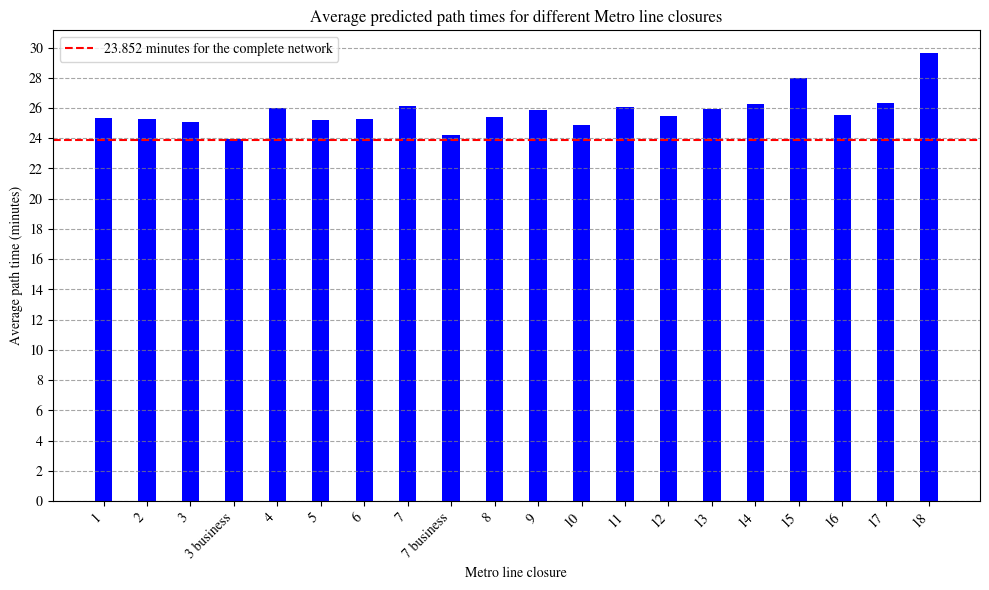

In [ ]:
# Extract lines and average times from path_times
modified_avg_times = list(line_closure_modified_avg_times.values())
lines = list(line_closure_modified_avg_times.keys())

# Replace "3.5" and "7.5" in lines list
lines = [str(line).replace("3.5", "3 business").replace("7.5", "7 business") for line in lines]

# Create evenly spaced x-axis positions
x_pos = np.arange(len(lines))

# Create the bar graph with fixed width
plt.figure(figsize=(10, 6))
plt.bar(x_pos, modified_avg_times, color='blue', width=0.4)  # Set width to 0.8

# Add horizontal line (threshold)
threshold_value = 23.852258540567696 # The threshold value
plt.axhline(y=threshold_value, color='red', linestyle='--', label=f'{threshold_value:.3f} minutes for the complete network')

# Customize the graph
plt.xlabel("Metro line closure")
plt.ylabel("Average path time (minutes)")
plt.title("Average predicted path times for different Metro line closures")
plt.xticks(x_pos, lines, rotation=45, ha='right')  # Label each bar
plt.yticks(np.arange(0, max(modified_avg_times) + 2, 2))  # Set y-axis ticks every 2 units
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)  # Add horizontal grid lines
plt.legend()  # Show legend including threshold line

# Display the graph
plt.tight_layout()
plt.savefig("average_times_closures.pdf", bbox_inches='tight')